# 整体思路
思路是使用Unet网络，输入三通道图片和掩膜，

掩膜是所有钢筋画到一副二值图上，每个钢筋只画中心点，半径为min(w, h)/3，

然后进行50次迭代，

使用大津法（OTSU）将生成的概率图二值化，最后识别结果轮廓，得到每个钢筋的小框

最后比较预测的个数与实际的个数得到效果

In [1]:
import numpy as np

import polars as pl
import cv2
import os

# 读取并绘制掩码

In [ ]:
csv_df = pl.read_csv('rec/data/train_labels.csv').select([
    'ID',
    pl.col(' Detection').alias('Detection')
])

In [ ]:
def draw_seg(lst, origin):
    mask = np.zeros(origin.shape[:2], dtype=np.uint8)
    for sample in lst:
        x_min, y_min, x_max, y_max = [int(i) for i in sample[1].split(' ')]
        # 根据rect绘制掩膜二值化
        # mask[y_min:y_max, x_min:x_max] = 255
        center_x, center_y = ((x_min + x_max) / 2, (y_min + y_max) / 2)
        w, h = x_max - x_min, y_max - y_min
        r = min(w, h)/3
        cv2.circle(mask, (int(center_x), int(center_y)), int(r), (255, 255, 255), -1)
        # box = cv2.boxPoints((center, (w,h), 0))
        # mask = cv2.drawContours(origin, [box.astype(int)], -1, (0, 255, 0), -1)
    return mask

In [ ]:
mask_dir = f'rec/data/mask'
os.makedirs(mask_dir, exist_ok=True)
for id, df in csv_df.group_by(['ID']):
    print(id[0], df)
    origin = cv2.imread(f'rec/data/train_dataset/{id[0]}')
    
    cv2.imwrite(f'{mask_dir}/{id[0]}', draw_seg(df.to_numpy(), origin))

# unet训练

In [2]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import tensorflow as tf
tf.__version__

D:\software\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.14.0'

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
def ct_preprocessing_function(ct):
    ct = ct / 255.
    return ct

In [6]:
from keras.preprocessing.image import ImageDataGenerator

ct_data_gen = ImageDataGenerator(
    preprocessing_function=ct_preprocessing_function
)

In [7]:
def mask_preprocessing_function(mask):
    mask = mask / 255.
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return mask

In [8]:
mask_data_gen = ImageDataGenerator(
    preprocessing_function=mask_preprocessing_function
)

In [9]:
generator_path = './rec/data'

In [10]:
ct_generator = ct_data_gen.flow_from_directory(
    generator_path,
    classes=['train_dataset'],
    class_mode=None,
    color_mode='rgb',
    target_size=(128, 128),
    batch_size=32,
    seed=42
)

Found 250 images belonging to 1 classes.


In [11]:
mask_generator = mask_data_gen.flow_from_directory(
    generator_path,
    classes = ['mask'], # 处理的文件夹
    class_mode = None,
    color_mode = 'grayscale', # 灰度图
    target_size = (128,128), # 输出图片大小
    batch_size = 32, # 批量大小
    # save_to_dir
    # save_prefix = 'mask_'
    seed = 42
)

Found 250 images belonging to 1 classes.


# 搭建模型

In [12]:
from tensorflow.keras.layers import *

In [13]:
import tensorflow as tf 

img_height = 128
img_width = 128
channel = 3

In [14]:
input_ = Input((img_height, img_width, channel))

In [15]:
# 编码器
# 第一块
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(input_)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)
p1 = Dropout(0.2)(p1) 

# 第二块
c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)
p2 = Dropout(0.2)(p2)

# 第三块
c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)
p3 = Dropout(0.2)(p3)

# 第四块
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)
p4 = Dropout(0.2)(p4)

# 第五块
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# 解码器
# 第四层
u6 = Conv2DTranspose(128, (2,2), strides = (2,2), padding='same')(c5)
u6 = concatenate([u6,c4])
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# 第三层
u7 = Conv2DTranspose(64, (2,2), strides = (2,2), padding='same')(c6)
u7 = concatenate([u7,c3])
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# 第二层
u8 = Conv2DTranspose(32, (2,2), strides = (2,2), padding='same')(c7)
u8 = concatenate([u8,c2])
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# 第一层
u9 = Conv2DTranspose(16, (2,2), strides = (2,2), padding='same')(c8)
u9 = concatenate([u9,c1])
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# 输出层
outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

In [16]:
model = tf.keras.Model(inputs = [input_],outputs = [outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [17]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [18]:
train_history = model.fit(zip(ct_generator,mask_generator),
                         epochs = 50,
                         steps_per_epoch=len(ct_generator)) 

Epoch 1/50
8/8 [==============================] - 35s 4s/step - loss: 0.7330 - accuracy: 0.5573
Epoch 2/50
8/8 [==============================] - 32s 4s/step - loss: 0.4528 - accuracy: 0.8782
Epoch 3/50
8/8 [==============================] - 31s 4s/step - loss: 0.3554 - accuracy: 0.8809
Epoch 4/50
8/8 [==============================] - 26s 3s/step - loss: 0.3168 - accuracy: 0.8811
Epoch 5/50
8/8 [==============================] - 26s 3s/step - loss: 0.2963 - accuracy: 0.8811
Epoch 6/50
8/8 [==============================] - 46s 6s/step - loss: 0.2831 - accuracy: 0.8812
Epoch 7/50
8/8 [==============================] - 53s 6s/step - loss: 0.2708 - accuracy: 0.8813
Epoch 8/50
8/8 [==============================] - 37s 4s/step - loss: 0.2621 - accuracy: 0.8817
Epoch 9/50
8/8 [==============================] - 29s 4s/step - loss: 0.2545 - accuracy: 0.8824
Epoch 10/50
8/8 [==============================] - 32s 4s/step - loss: 0.2482 - accuracy: 0.8831
Epoch 11/50
8/8 [======================

In [24]:
#保存 model
os.makedirs('rec/model', exist_ok=True)
model.save('rec/model/segmentation_model.keras')

# 输出结果

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']= False

In [34]:
import os
def file_iter(path):
    for fname in os.listdir(path):
        file_path = os.path.join(path, fname)
        if os.path.isfile(file_path):
            yield file_path, cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)

In [35]:
import cv2
import pandas as pd

df = []
for index, (path, i) in enumerate(file_iter('./rec/data/test_dataset')):
    # 转换为128, 128
    img = cv2.resize(i, (128, 128))
    
    fig, axes = plt.subplots(figsize=(16,24), nrows=1, ncols=4)
    axes[0].imshow(img)
    axes[0].set_title('原图')
    
    
    y_hat = model.predict(np.expand_dims(img,axis=0))
    axes[1].imshow(y_hat[0])
    axes[1].set_title("预测图")

    y_hat_256 = (y_hat[0]*255).astype(np.uint8)
    _, otsu = cv2.threshold(y_hat_256,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask_otsu = np.zeros_like(otsu)
    draw_img = img.copy().astype(np.uint8)
    contours, hierarchy = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h_scale = i.shape[0] / 128
    w_scale = i.shape[1] / 128
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if min(w, h) < 3:
            continue
        cv2.rectangle(mask_otsu, (x, y), (x + w, y + h), (255, 255, 255), 1)
        cv2.rectangle(draw_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
        
        df.append([os.path.basename(path),f"{int(x*w_scale)} {int(y*h_scale)} {int((x+w)*w_scale)} {int((y+h)*h_scale)}"])
        
        # print(f'rect: {rect}')
    axes[2].imshow(mask_otsu)
    axes[2].set_title("预测图二值化")

    axes[3].imshow(draw_img)
    axes[3].set_title("结果框绘制")
    
    os.makedirs('./rec/data/test_result', exist_ok=True)
    fig.savefig(f'./rec/data/test_result/{os.path.basename(path)}')
    plt.close(fig)

    # plt.show()
    # if index > 2:
    #     break
pddf = pd.DataFrame(df)
pddf.to_csv('rec/data/test_labels.csv', index=False, header=['ID', 'labels'])

1/1 [==============================] - 0s 36ms/step


In [36]:
df = []
for index, (path, i) in enumerate(file_iter('./rec/data/train_dataset')):
    # 转换为128, 128
    img = cv2.resize(i, (128, 128))
    
    fig, axes = plt.subplots(figsize=(16,24), nrows=1, ncols=4)
    axes[0].imshow(img)
    axes[0].set_title('原图')
    
    
    y_hat = model.predict(np.expand_dims(img,axis=0))
    axes[1].imshow(y_hat[0])
    axes[1].set_title("预测图")

    y_hat_256 = (y_hat[0]*255).astype(np.uint8)
    _, otsu = cv2.threshold(y_hat_256,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask_otsu = np.zeros_like(otsu)
    draw_img = img.copy().astype(np.uint8)
    contours, hierarchy = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h_scale = i.shape[0] / 128
    w_scale = i.shape[1] / 128
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if min(w, h) < 3:
            continue
        cv2.rectangle(mask_otsu, (x, y), (x + w, y + h), (255, 255, 255), 1)
        cv2.rectangle(draw_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
        
        df.append([os.path.basename(path),f"{int(x*w_scale)} {int(y*h_scale)} {int((x+w)*w_scale)} {int((y+h)*h_scale)}"])
        
        # print(f'rect: {rect}')
    axes[2].imshow(mask_otsu)
    axes[2].set_title("预测图二值化")

    axes[3].imshow(draw_img)
    axes[3].set_title("结果框绘制")
    
    os.makedirs('./rec/data/train_result', exist_ok=True)
    fig.savefig(f'./rec/data/train_result/{os.path.basename(path)}')
    plt.close(fig)

    # plt.show()
    # if index > 2:
    #     break
pddf = pd.DataFrame(df)
pddf.to_csv('rec/data/train__labels.csv', index=False, header=['ID', 'Detection'])

1/1 [==============================] - 0s 36ms/step


# 比较数据

In [51]:
import polars as pl

origin = pl.read_csv('rec/data/train_labels.csv').select([
    'ID',
    pl.col(' Detection').alias('Detection')
]).group_by(['ID']).agg(
    pl.col('Detection').count().alias('origin')
)
pred = pl.read_csv('rec/data/train__labels.csv').group_by(['ID']).agg(
    pl.col('Detection').count().alias('pred')
)

In [74]:
joined = origin.join(pred, on='ID', how='left').with_columns([
    (pl.col('origin').cast(pl.Int32) - pl.col('pred').cast(pl.Int32)).abs().alias('delta')
])
joined

ID,origin,pred,delta
str,u32,u32,i32
"""3BA38AEA.jpg""",112,89,23
"""2A7090FC.jpg""",94,75,19
"""CCB5DBEF.jpg""",80,78,2
"""EFE77AB2.jpg""",119,105,14
"""4463FA64.jpg""",157,57,100
…,…,…,…
"""408EAD06.jpg""",95,90,5
"""7E0BEC70.jpg""",73,78,5
"""D4E8F388.jpg""",93,89,4


## 绘制QQ图

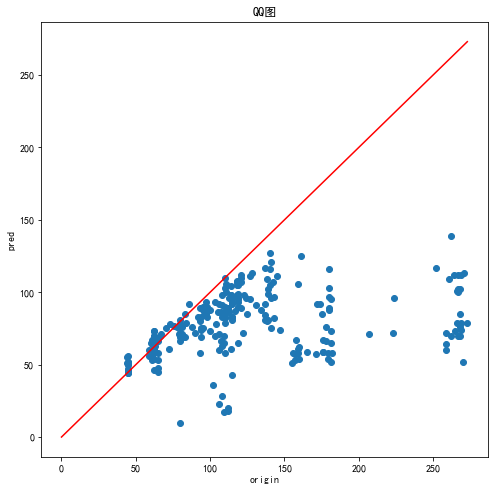

In [78]:
plt.figure(figsize=(8, 8))
plt.title('QQ图')
plt.plot(joined['origin'].to_numpy(), joined['pred'].to_numpy(), 'o')
max_p = max(joined['origin'].to_numpy().max(), joined['pred'].to_numpy().max())
plt.plot([0, max_p], [0, max_p], 'r')
plt.xlabel('origin')
plt.ylabel('pred')
plt.savefig('rec/data/qq.png')

## 绘制delta直方图

In [79]:
print(joined['delta'].to_numpy().max())

218


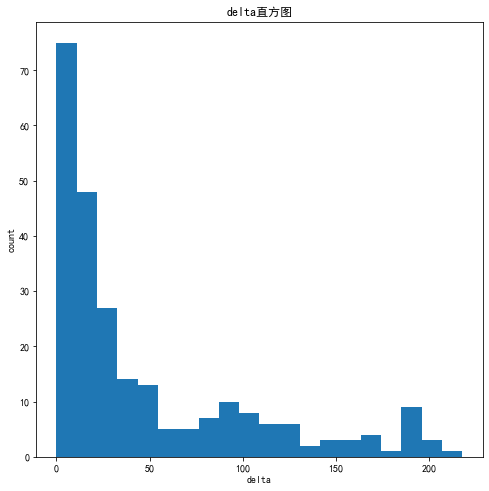

In [80]:
plt.figure(figsize=(8, 8))
plt.title('delta直方图')
plt.hist(joined['delta'].to_numpy(), bins=20)
plt.xlabel('delta')
plt.ylabel('count')
plt.savefig('rec/data/delta_hist.png')